<a href="https://colab.research.google.com/github/NikuDubenco/DS-Unit-2-Regression-2/blob/master/Nicolae_Dubenco_Cross_Validation%2C_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [18]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: data.zip                


In [19]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv 

### Wrangle data

In [0]:
import category_encoders as ce
from glob import glob
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

In [0]:
#read data
train = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')
tube = pd.read_csv('competition_data/tube.csv')
materials = pd.read_csv('competition_data/bill_of_materials.csv')
components = pd.read_csv('competition_data/components.csv')
comp = pd.concat((pd.read_csv(path) for path in glob('competition_data/comp_*.csv')), sort=False)

In [0]:
comp.describe()

,adaptor_angle,overall_length,hex_size,length_1,thread_size_1,thread_pitch_1,length_2,thread_size_2,thread_pitch_2,nominal_size_2,length_3,thread_size_3,thread_pitch_3,nominal_size_3,length_4,thread_size_4,thread_pitch_4,nominal_size_4,weight,bolt_pattern_long,bolt_pattern_wide,extension_length,thickness,drop_length,elbow_angle,plug_diameter,height_over_tube,base_diameter,shoulder_diameter,hose_diameter,head_diameter,length,intended_nut_thread,intended_nut_pitch,hex_nut_size,seat_angle,thread_pitch,diameter
count,55.000000,365.000000,129.000000,74.000000,152.000000,152.000000,74.000000,86.000000,86.000000,133.000000,19.000000,10.000000,10.000000,9.000000,1.0,1.000,1.0,0.0,1976.000000,505.000000,379.000000,174.000000,552.00000,175.000000,130.000000,7.000000,147.000000,57.000000,30.000000,6.000000,70.000000,115.000000,50.000000,50.000000,42.000000,15.000000,65.000000,23.000000
mean,89.181818,59.342356,30.496279,39.917973,1.012822,14.266447,33.997027,117.253302,130.668605,95.457594,35.513158,1.262100,12.800000,1128.806667,41.7,1.187,12.0,NaN,0.774849,69.716257,38.347098,48.838966,29.37058,88.059771,91.618077,50.142857,88.239796,29.884912,23.498000,11.933333,58.414000,715.739191,1.057160,14.360000,29.810476,38.600000,11.576923,19.800000
std,6.067799,32.656994,11.419443,13.656981,0.374932,2.797775,11.170766,1078.112403,1076.654378,865.299101,13.130247,0.269601,1.398412,3326.333176,NaN,NaN,NaN,NaN,1.369687,22.324257,17.244890,15.004189,20.25099,753.632145,8.433971,19.445896,823.069326,8.949617,8.466898,8.549542,17.766911,2549.496081,0.422217,2.545584,11.528083,3.312315,6.230426,6.680692
min,45.000000,12.700000,9.400000,15.880000,0.125000,8.000000,0.000000,0.125000,11.500000,6.350000,14.500000,0.812000,12.000000,9.520000,41.7,1.187,12.0,NaN,0.001000,36.070000,17.000000,16.500000,3.76000,7.900000,90.000000,25.000000,4.760000,14.000000,12.240000,4.800000,38.000000,1.000000,0.437000,12.000000,14.290000,37.000000,1.000000,0.625000
25%,90.000000,32.260000,22.220000,30.652500,0.750000,12.000000,28.000000,0.750000,12.000000,13.720000,25.905000,1.046750,12.000000,15.880000,41.7,1.187,12.0,NaN,0.081750,52.400000,26.200000,39.000000,14.20000,22.350000,90.000000,35.000000,15.575000,25.000000,18.050000,4.800000,45.245000,14.750000,0.702750,12.000000,22.055000,37.000000,12.000000,17.500000
50%,90.000000,54.000000,28.580000,37.300000,1.000000,14.000000,35.250000,1.000000,14.000000,19.050000,37.000000,1.312000,12.000000,15.880000,41.7,1.187,12.0,NaN,0.263500,63.500000,31.750000,49.255000,25.00000,26.930000,90.000000,50.000000,18.800000,28.000000,22.360000,10.350000,50.800000,20.000000,1.000000,14.000000,25.400000,37.000000,13.000000,20.000000
75%,90.000000,78.500000,38.100000,43.525000,1.187000,16.000000,41.350000,1.187000,16.000000,25.400000,41.700000,1.437000,13.500000,30.000000,41.7,1.187,12.0,NaN,0.900250,79.250000,42.900000,55.000000,36.50000,35.075000,90.000000,65.000000,24.000000,33.380000,27.297500,15.900000,65.325000,27.500000,1.405750,16.000000,35.730000,37.000000,16.000000,25.000000
max,90.000000,190.550000,76.200000,71.100000,2.500000,27.000000,61.200000,9999.000000,9999.000000,9999.000000,71.200000,1.687000,16.000000,9999.000000,41.7,1.187,12.0,NaN,13.770000,158.800000,120.000000,125.000000,127.70000,9999.000000,169.250000,76.000000,9999.000000,60.000000,52.370000,25.400000,127.000000,9999.000000,2.000000,20.000000,57.150000,45.000000,20.000000,30.000000


In [0]:
# get a tidy list of the component types in each tube assembly
assembly_components = materials.melt(id_vars='tube_assembly_id',
                                    value_vars=[f'component_id_{n}' for n in range(1,9)])
assembly_components = assembly_components.sort_values(
    by='tube_assembly_id').dropna().rename(columns={'value': 'component_id'})

assembly_component_types = assembly_components.merge(components, how='left')

In [0]:
table = pd.crosstab(assembly_component_types['tube_assembly_id'],
                   assembly_component_types['component_type_id'])
table = table.reset_index()

In [24]:
table

component_type_id,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,CP-010,CP-011,CP-012,CP-014,CP-015,CP-016,CP-017,CP-018,CP-019,CP-020,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
5,TA-00006,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
6,TA-00007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
7,TA-00008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,TA-00009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
9,TA-00010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
features = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[features]
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

In [0]:
# get agg features for all components in each tube assembly
# this code is a little complex, but we discussed in detail last lesson

materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0) for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
  materials = materials.merge(comp, how='left',
                             left_on=f'component_id_{n}',
                             right_on='component_id',
                             suffixes=('', f'_{n}'))
  
for col in materials:
  if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
    materials[col] = materials[col].fillna(0)
    
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 'components_total',
           'components_distinct', 'component_id_1']
materials = materials[features]

In [0]:
# extract year from quote date
train['quote_date_year'] = pd.to_datetime(train['quote_date'], infer_datetime_format=True).dt.year
test['quote_date_year'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True).dt.year

In [0]:
# merge data
train = (train
        .merge(tube, how='left')
        .merge(materials, how='left')
        .merge(table, how='left')
        .fillna(0))

test = (test
       .merge(tube, how='left')
       .merge(materials, how='left')
       .merge(table, how='left')
       .fillna(0))

# arrange X matrix and y vector.
# drop 'tube_assembly_id' because our goal is to predict unknown assemblies,
# and no tube assembly_id's are shared between the train and test sets
target = 'cost'
features = train.columns.drop([target, 'tube_assembly_id'])
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [31]:
y_train.describe()

count    30213.000000
mean        13.433317
std         28.663200
min          0.503553
25%          3.878190
50%          6.521146
75%         13.431781
max       1000.000000
Name: cost, dtype: float64

In [0]:
# log-transform the target
y_train_log = np.log1p(y_train)

# make pipeline
pipeline = make_pipeline(ce.OrdinalEncoder(),
                        RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42))

### cross_val_score

In [35]:
%%time
from sklearn.model_selection import cross_val_score

k=3
groups = train['tube_assembly_id']
scores = cross_val_score(pipeline, X_train, y_train_log, cv=k,
                       scoring='neg_mean_squared_error', groups=groups)

print(f'RMSLE for {k} folds:', np.sqrt(-scores))

RMSLE for 3 folds: [0.29148895 0.32165194 0.34699508]
CPU times: user 2.91 s, sys: 370 ms, total: 3.29 s
Wall time: 35.6 s


In [36]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestregressor'])

Model Hyperparameters:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


### validation curve

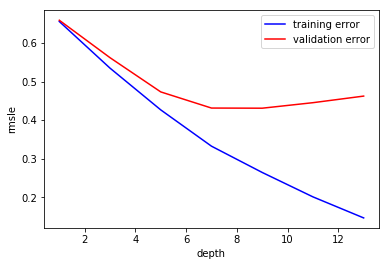

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor())

depth = range(1, 15, 2)

train_scores, val_scores = validation_curve(pipeline, X_train, y_train_log, 
                                           param_name='decisiontreeregressor__max_depth',
                                           param_range=depth, scoring='neg_mean_squared_error',
                                           cv=2, groups=groups)

train_rmsle = np.sqrt(-train_scores)
val_rmsle = np.sqrt(-val_scores)

plt.plot(depth, np.mean(train_rmsle, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_rmsle, axis=1), color='r', label='validation error')
plt.xlabel('depth')
plt.ylabel('rmsle')
plt.legend();

In [45]:
# use scikit-learn for hyperparameter optimization
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(ce.OrdinalEncoder(),
                        RandomForestRegressor(random_state=42))

param_distributions = {
    'randomforestregressor__n_estimators': randint(50,500),
    'randomforestregressor__max_features': uniform(),
    'randomforestregressor__min_samples_leaf': [1,10,100]
}

search = RandomizedSearchCV(pipeline,
                           param_distributions=param_distributions,
                           n_iter=5,
                           cv=2,
                           scoring='neg_mean_squared_error',
                           verbose=10,
                           return_train_score=True,
                           n_jobs=-1)

search.fit(X_train, y_train_log, groups=groups)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.0s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    criterion='mse',
                                    

In [46]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'randomforestregressor__max_features': 0.4229655360081511, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 143}
Cross-validation RMSLE 0.3274006006106637


### xgboost

In [48]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pipeline = make_pipeline(ce.OrdinalEncoder(),
                        XGBRegressor(random_state=42))

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000),
    'xgbregressor__max_depth': randint(3, 7)
}

search = RandomizedSearchCV(pipeline,
                           param_distributions=param_distributions,
                           n_iter=5,
                           cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)

search.fit(X_train, y_train_log, groups=groups)

[00:41:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           col

In [49]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 772}
Cross-validation RMSLE 0.31132190861521936


In [50]:
results_df = pd.DataFrame(search.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,17.253082,0.047230,0.345341,0.007546,3,529,"{'xgbregressor__max_depth': 3, 'xgbregressor__...",-0.093027,-0.120553,-0.106789,0.013763,4,-0.045638,-0.034240,-0.039939,0.005699
1,40.879156,0.101812,1.003466,0.007877,6,664,"{'xgbregressor__max_depth': 6, 'xgbregressor__...",-0.084970,-0.110198,-0.097584,0.012614,2,-0.005480,-0.003086,-0.004283,0.001197
2,28.357624,0.104783,0.528365,0.019912,4,680,"{'xgbregressor__max_depth': 4, 'xgbregressor__...",-0.082511,-0.118503,-0.100507,0.017996,3,-0.022280,-0.015320,-0.018800,0.003480
3,26.785550,0.126375,0.498027,0.007211,3,819,"{'xgbregressor__max_depth': 3, 'xgbregressor__...",-0.092702,-0.123255,-0.107978,0.015277,5,-0.036536,-0.026986,-0.031761,0.004775
4,39.526289,0.150930,0.924883,0.009035,5,772,"{'xgbregressor__max_depth': 5, 'xgbregressor__...",-0.086682,-0.107162,-0.096921,0.010240,1,-0.010060,-0.006231,-0.008145,0.001914


In [51]:
results_df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
4,39.526289,0.150930,0.924883,0.009035,5,772,"{'xgbregressor__max_depth': 5, 'xgbregressor__...",-0.086682,-0.107162,-0.096921,0.010240,1,-0.010060,-0.006231,-0.008145,0.001914
1,40.879156,0.101812,1.003466,0.007877,6,664,"{'xgbregressor__max_depth': 6, 'xgbregressor__...",-0.084970,-0.110198,-0.097584,0.012614,2,-0.005480,-0.003086,-0.004283,0.001197
2,28.357624,0.104783,0.528365,0.019912,4,680,"{'xgbregressor__max_depth': 4, 'xgbregressor__...",-0.082511,-0.118503,-0.100507,0.017996,3,-0.022280,-0.015320,-0.018800,0.003480
0,17.253082,0.047230,0.345341,0.007546,3,529,"{'xgbregressor__max_depth': 3, 'xgbregressor__...",-0.093027,-0.120553,-0.106789,0.013763,4,-0.045638,-0.034240,-0.039939,0.005699
3,26.785550,0.126375,0.498027,0.007211,3,819,"{'xgbregressor__max_depth': 3, 'xgbregressor__...",-0.092702,-0.123255,-0.107978,0.015277,5,-0.036536,-0.026986,-0.031761,0.004775


### make prediction

In [0]:
pipeline = search.best_estimator_
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log) # convert from log-dollars to dollars
submission = pd.read_csv('sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('submission.csv', index=False)